In [48]:
import torch
import torch.nn as nn

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

In [49]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


# Dataset Args
n_classes = 2**2
m = 10
n_epochs = 100
hidden = [3]*5
architecture = [2] + hidden + [n_classes]

print(architecture)

args_dict = {
    'seed': 2024,
    'kan_architecture': architecture,
    'grid': 5,
    'k': 3,
    'bounds': (-1,1),
    'learning_rate': 1e-3,
}
args = Args(**args_dict)

[2, 3, 3, 3, 3, 3, 4]


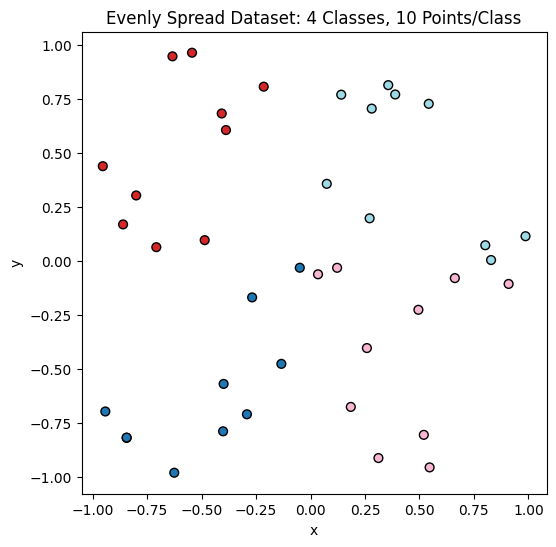

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def create_evenly_spread_dataset(n_classes=32, m=3, bounds=(-1, 1), seed=42):
    np.random.seed(seed)
    # Compute grid size (try to make it as square as possible)
    grid_size = int(np.ceil(np.sqrt(n_classes)))
    x_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    y_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    data = []
    labels = []
    class_idx = 0
    for i in range(grid_size):
        for j in range(grid_size):
            if class_idx >= n_classes:
                break
            x_min, x_max = x_edges[i], x_edges[i+1]
            y_min, y_max = y_edges[j], y_edges[j+1]
            # Sample m points uniformly within this cell
            xs = np.random.uniform(x_min, x_max, size=(m, 1))
            ys = np.random.uniform(y_min, y_max, size=(m, 1))
            points = np.hstack([xs, ys])
            data.append(points)
            labels.extend([class_idx] * m)
            class_idx += 1
        if class_idx >= n_classes:
            break
    data = np.vstack(data)
    labels = np.array(labels)
    return data, labels


data, labels = create_evenly_spread_dataset(n_classes=n_classes, m=m, bounds=(-1, 1))

plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', edgecolor='k', s=40)
plt.title(f'Evenly Spread Dataset: {n_classes} Classes, {m} Points/Class')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

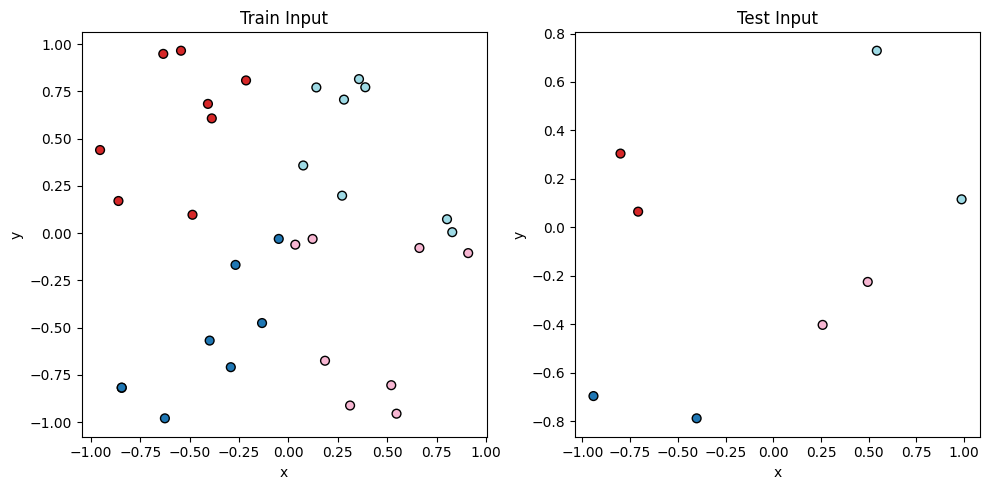

In [51]:
from sklearn.model_selection import train_test_split

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

train_input, test_input, train_label, test_label = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

dataset = {}
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot train input
axs[0].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
               c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[0].set_title('Train Input')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot test input
axs[1].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
               c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[1].set_title('Test Input')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()

checkpoint directory created: ./model
saving model version 0.0
Epoch 1/100, Loss: 1.3862, Test Acc: 0.5000
Epoch 10/100, Loss: 1.3857, Test Acc: 0.2500
Epoch 10/100, Loss: 1.3857, Test Acc: 0.2500
Epoch 20/100, Loss: 1.3846, Test Acc: 0.2500
Epoch 20/100, Loss: 1.3846, Test Acc: 0.2500
Epoch 30/100, Loss: 1.3819, Test Acc: 0.5000
Epoch 30/100, Loss: 1.3819, Test Acc: 0.5000
Epoch 40/100, Loss: 1.3750, Test Acc: 0.5000
Epoch 40/100, Loss: 1.3750, Test Acc: 0.5000
Epoch 50/100, Loss: 1.3586, Test Acc: 0.5000
Epoch 50/100, Loss: 1.3586, Test Acc: 0.5000
Epoch 60/100, Loss: 1.3258, Test Acc: 0.5000
Epoch 60/100, Loss: 1.3258, Test Acc: 0.5000


Epoch 70/100, Loss: 1.2742, Test Acc: 0.5000
Epoch 80/100, Loss: 1.2141, Test Acc: 0.5000
Epoch 80/100, Loss: 1.2141, Test Acc: 0.5000
Epoch 90/100, Loss: 1.1586, Test Acc: 0.5000
Epoch 90/100, Loss: 1.1586, Test Acc: 0.5000
Epoch 100/100, Loss: 1.1107, Test Acc: 0.5000
Epoch 100/100, Loss: 1.1107, Test Acc: 0.5000


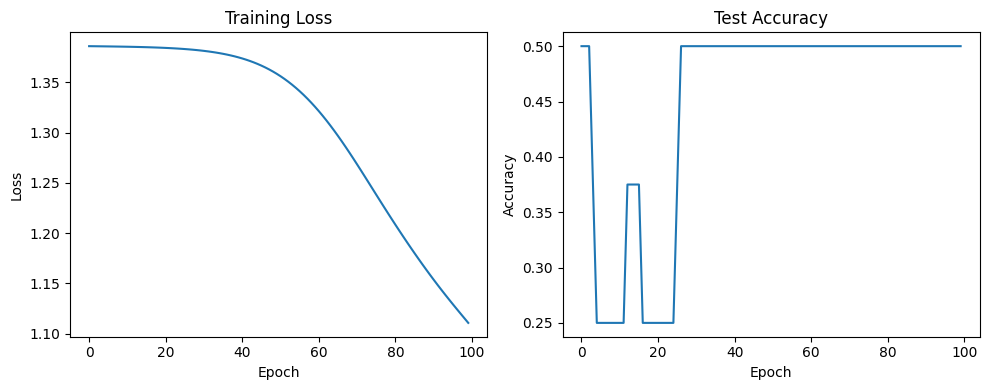

In [52]:
# Import KAN and train a standard KAN model
from kan import KAN
import torch.optim as optim
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(args.seed)

# Initialize KAN model
kan = KAN(width=args.kan_architecture, grid=args.grid, k=args.k, grid_range=args.bounds).to(device)

optimizer = optim.Adam(kan.parameters(), lr=args.learning_rate)

train_X = dataset['train_input']
train_y = dataset['train_label']
test_X = dataset['test_input']
test_y = dataset['test_label']

train_losses = []
test_accuracies = []
for epoch in range(n_epochs):
    kan.train()
    optimizer.zero_grad()
    output = kan(train_X)
    loss = F.cross_entropy(output, train_y)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluate
    kan.eval()
    with torch.no_grad():
        test_output = kan(test_X)
        pred = test_output.argmax(dim=1)
        acc = (pred == test_y).float().mean().item()
        test_accuracies.append(acc)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

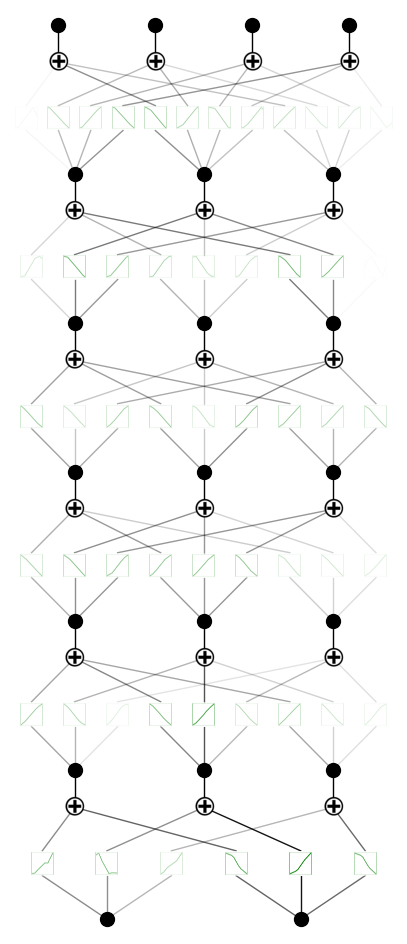

In [53]:
kan.plot()

## Train a KAN on the Dataset
We will import the KAN model and train it on the generated dataset.

## Train a Monotonic KAN
Now, we train a KAN where the coefficients are constrained to be monotonic (increasing or decreasing).

checkpoint directory created: ./model
saving model version 0.0
[Monotonic] Epoch 1/100, Loss: 1.3862, Test Acc: 0.5000


[Monotonic] Epoch 10/100, Loss: 1.3857, Test Acc: 0.2500
[Monotonic] Epoch 20/100, Loss: 1.3846, Test Acc: 0.2500
[Monotonic] Epoch 20/100, Loss: 1.3846, Test Acc: 0.2500
[Monotonic] Epoch 30/100, Loss: 1.3819, Test Acc: 0.5000
[Monotonic] Epoch 30/100, Loss: 1.3819, Test Acc: 0.5000
[Monotonic] Epoch 40/100, Loss: 1.3750, Test Acc: 0.5000
[Monotonic] Epoch 40/100, Loss: 1.3750, Test Acc: 0.5000
[Monotonic] Epoch 50/100, Loss: 1.3586, Test Acc: 0.5000
[Monotonic] Epoch 50/100, Loss: 1.3586, Test Acc: 0.5000
[Monotonic] Epoch 60/100, Loss: 1.3258, Test Acc: 0.5000
[Monotonic] Epoch 60/100, Loss: 1.3258, Test Acc: 0.5000
[Monotonic] Epoch 70/100, Loss: 1.2742, Test Acc: 0.5000
[Monotonic] Epoch 70/100, Loss: 1.2742, Test Acc: 0.5000
[Monotonic] Epoch 80/100, Loss: 1.2141, Test Acc: 0.5000
[Monotonic] Epoch 80/100, Loss: 1.2141, Test Acc: 0.5000
[Monotonic] Epoch 90/100, Loss: 1.1586, Test Acc: 0.5000
[Monotonic] Epoch 90/100, Loss: 1.1586, Test Acc: 0.5000
[Monotonic] Epoch 100/100, Loss

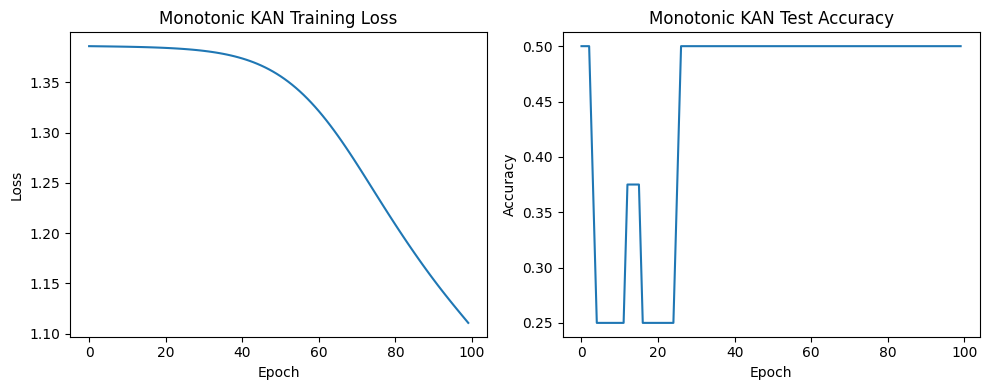

In [54]:
# Monotonic KAN: Inherit from KAN and enforce monotonic coefficients
from kan import KAN
import torch.optim as optim
import torch.nn.functional as F

class MonotonicKAN(KAN):
    def __init__(self, *args, monotonic_mode='increasing', **kwargs):
        super().__init__(*args, **kwargs)
        self.monotonic_mode = monotonic_mode

    def enforce_monotonicity(self):
        for name, param in self.named_parameters():
            if 'coeff' in name:
                if self.monotonic_mode == 'increasing':
                    param.data = torch.sort(param.data, dim=-1)[0]
                elif self.monotonic_mode == 'decreasing':
                    param.data = torch.sort(param.data, dim=-1, descending=True)[0]

    def step_and_enforce(self, optimizer):
        optimizer.step()
        self.enforce_monotonicity()

# Initialize a new MonotonicKAN model
kan_mono = MonotonicKAN(width=args.kan_architecture, grid=args.grid, k=args.k, grid_range=args.bounds, monotonic_mode='increasing').to(device)
optimizer_mono = optim.Adam(kan_mono.parameters(), lr=args.learning_rate)

train_losses_mono = []
test_accuracies_mono = []
for epoch in range(n_epochs):
    kan_mono.train()
    optimizer_mono.zero_grad()
    output = kan_mono(train_X)
    loss = F.cross_entropy(output, train_y)
    loss.backward()
    kan_mono.step_and_enforce(optimizer_mono)
    train_losses_mono.append(loss.item())

    # Evaluate
    kan_mono.eval()
    with torch.no_grad():
        test_output = kan_mono(test_X)
        pred = test_output.argmax(dim=1)
        acc = (pred == test_y).float().mean().item()
        test_accuracies_mono.append(acc)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"[Monotonic] Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses_mono)
plt.title('Monotonic KAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(test_accuracies_mono)
plt.title('Monotonic KAN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

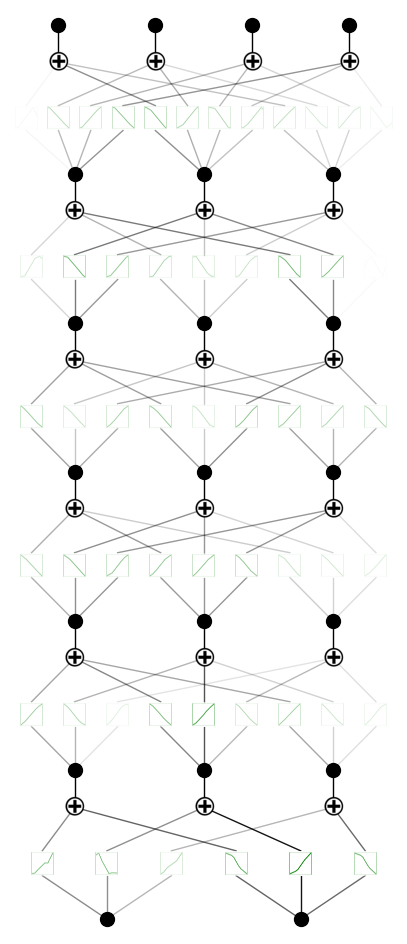

In [55]:
kan_mono.plot()

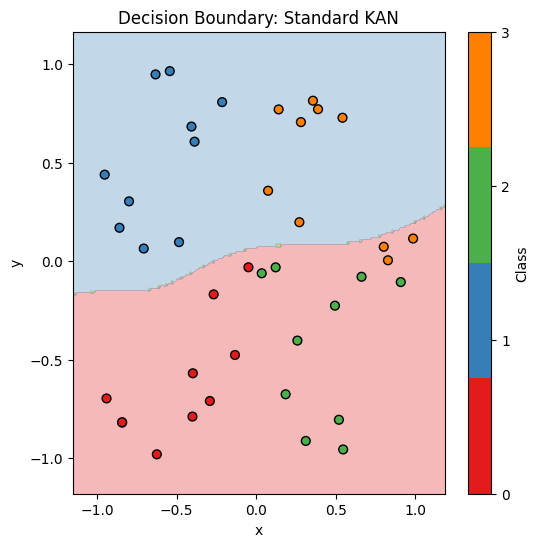

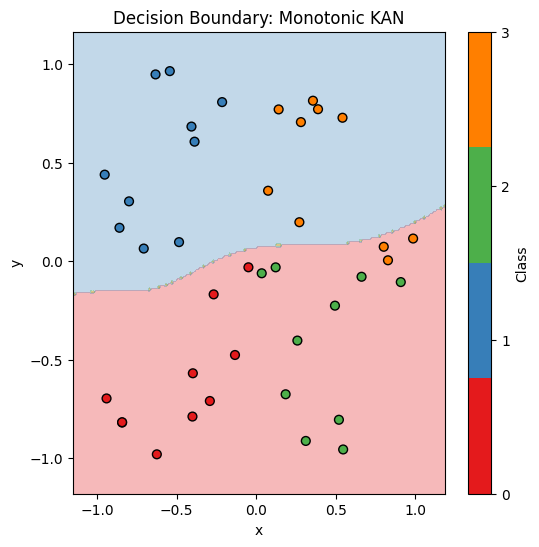

In [56]:
# Plot decision boundaries for both KAN experiments
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y, title, device, steps=200, n_classes=4):
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.from_numpy(grid).type(dtype).to(device)
    with torch.no_grad():
        logits = model(grid_tensor)
        preds = logits.argmax(dim=1).cpu().numpy()
    zz = preds.reshape(xx.shape)
    # Use a ListedColormap with 4 distinct colors
    cmap = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00'])
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, zz, alpha=0.3, cmap=cmap, levels=np.arange(n_classes+1)-0.5)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor='k', s=40, vmin=0, vmax=n_classes-1)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.colorbar(scatter, ticks=range(n_classes), label='Class')
    plt.show()

# Plot for standard KAN
plot_decision_boundary(kan, data, labels, 'Decision Boundary: Standard KAN', device, n_classes=n_classes)

# Plot for monotonic KAN
plot_decision_boundary(kan_mono, data, labels, 'Decision Boundary: Monotonic KAN', device, n_classes=n_classes)
